# Vector DB 데이터 저장 및 검색
- pinecone db 사용

In [14]:
from dotenv import load_dotenv
import os

# .env 파일에서 환경 변수를 로드합니다.
load_dotenv(override=True)

# 환경 변수에서 PINECONE_API_KEY를 가져옵니다.
PINECONE_API_KEY = os.environ['PINECONE_API_KEY']
PINECONE_API_KEY

'pcsk_5zaNC8_Tbx3BfJ587c2drtYZjbw34ZBNDmMtKjMtV93SAFiiG3pCJrkjnySoZtCQyNFqNd'

## Pinecone 클라이언트 초기화

###  pinecone 연결 index 객체 생성

In [15]:
from pinecone import Pinecone, ServerlessSpec

# Pinecone 클라이언트를 초기화합니다.
# PINECONE_API_KEY는 환경 변수에서 가져온 API 키입니다.
pc = Pinecone(api_key=PINECONE_API_KEY)

index_name = "embedding-test"
index = pc.Index(index_name)


## data  Upsert

In [16]:
index.describe_index_stats()

{'_response_info': {'raw_headers': {'connection': 'keep-alive',
                                    'content-length': '184',
                                    'content-type': 'application/json',
                                    'date': 'Mon, 29 Dec 2025 05:22:57 GMT',
                                    'grpc-status': '0',
                                    'server': 'envoy',
                                    'x-envoy-upstream-service-time': '59',
                                    'x-pinecone-request-id': '5465552442677663605',
                                    'x-pinecone-request-latency-ms': '58',
                                    'x-pinecone-response-duration-ms': '60'}},
 'dimension': 3,
 'index_fullness': 0.0,
 'memoryFullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'embedding-3d-ns1': {'vector_count': 6}},
 'storageFullness': 0.0,
 'total_vector_count': 6,
 'vector_type': 'dense'}

## 벡터 임베딩

In [21]:
# 벡터를 인덱스에 업서트(upsert)합니다.
# "embedding-3d-ns1" 네임스페이스에 벡터를 추가합니다.

vectors=[
    {
        "id": "vec1",
        "values": [1.0, 1.5, 2.0],  # 임베딩 벡터, 행벡터 3차원
        "metadata": {"genre": "drama"}  # 
    }, {
        "id": "vec2",
        "values": [2.0, 1.0, 0.5],
        "metadata": {"genre": "action"}
    }, {
        "id": "vec3",
        "values": [0.1, 0.3, 0.5],
        "metadata": {"genre": "drama"}
    }, {
        "id": "vec4",
        "values": [1.0, 2.5, 3.5],
        "metadata": {"genre": "action"}
    }, {
        "id": "vec5",
        "values": [3.0, 1.2, 1.3],
        "metadata": {"genre": "action"}
    }, {
        "id": "vec6",
        "values": [0.3, 1.1, 2.5],
        "metadata": {"genre": "drama"}
    }
]
# namespace="embedding-3d-ns1"  # namespace를 만들면 서칭 속도가 빨라짐 가능

## 벡터 db(pinecone)에 저장

In [22]:
index.upsert(vectors)

UpsertResponse(upserted_count=6, _response_info={'raw_headers': {'date': 'Mon, 29 Dec 2025 05:28:22 GMT', 'content-type': 'application/json', 'content-length': '19', 'connection': 'keep-alive', 'x-pinecone-request-lsn': '1', 'x-pinecone-request-logical-size': '207', 'x-pinecone-request-latency-ms': '236', 'x-pinecone-request-id': '668133191689739400', 'x-envoy-upstream-service-time': '237', 'x-pinecone-response-duration-ms': '238', 'grpc-status': '0', 'server': 'envoy'}})

In [24]:
index.upsert(
    vectors,
    namespace="embedding-3d-ns1"
)

UpsertResponse(upserted_count=6, _response_info={'raw_headers': {'date': 'Mon, 29 Dec 2025 05:29:00 GMT', 'content-type': 'application/json', 'content-length': '19', 'connection': 'keep-alive', 'x-pinecone-request-lsn': '2', 'x-pinecone-request-logical-size': '207', 'x-pinecone-request-latency-ms': '216', 'x-pinecone-request-id': '81054103996071372', 'x-envoy-upstream-service-time': '218', 'x-pinecone-response-duration-ms': '220', 'grpc-status': '0', 'server': 'envoy'}})

## 검색 조건 내에서 검색하기
- 검색을 할 때 메타데이터 기반으로 필터링한 결과 내에서 top-k를 검색함

In [26]:
quary_data = "코믹 영화 장르"
response = index.query(
    namespace="embedding-3d-ns1",
    vector=[0.1, 0.3, 0.7], # 쿼리 벡터로 만들기
    top_k=2, # 검색 갯수
    include_values=True, # 벡터 데이터
    include_metadata=True, # 메타데이터 포함 여부
    filter={   # where 절 같은것
        "genre": {"$eq": "drama"}
    }

)

print(response)

QueryResponse(matches=[{'id': 'vec6',
 'metadata': {'genre': 'drama'},
 'score': 1.00006485,
 'values': [0.3, 1.1, 2.5]}, {'id': 'vec3',
 'metadata': {'genre': 'drama'},
 'score': 0.990785182,
 'values': [0.1, 0.3, 0.5]}], namespace='embedding-3d-ns1', usage={'read_units': 1}, _response_info={'raw_headers': {'date': 'Mon, 29 Dec 2025 05:29:56 GMT', 'content-type': 'application/json', 'content-length': '252', 'connection': 'keep-alive', 'x-pinecone-max-indexed-lsn': '2', 'x-pinecone-request-latency-ms': '35', 'x-pinecone-request-id': '8732549422899833959', 'x-envoy-upstream-service-time': '35', 'x-pinecone-response-duration-ms': '37', 'grpc-status': '0', 'server': 'envoy'}})


In [27]:
# embedding-3d-ns1 네임스페이스의 모든 레코드 id를 조회합니다.
for ids in index.list(namespace="embedding-3d-ns1"):
    print(ids)

['vec1', 'vec2', 'vec3', 'vec4', 'vec5', 'vec6']


In [28]:
# 지정된 네임스페이스(embedding-3d-ns1)에 있는 모든 ID를 리스트 형태로 반환합니다.
for ids in index.list(namespace="embedding-3d-ns1"):
    # 주어진 ID와 네임스페이스에 해당하는 벡터 데이터를 가져옵니다.
    # 반환된 데이터는 딕셔너리 형태이며, 
    # 그 중에서 'vectors' 키에 해당하는 값을 vectors 변수에 저장합니다.
    # vectors = index.fetch(ids, namespace="embedding-3d-ns1")
    # print(vectors)
    vectors = index.fetch(ids, namespace="embedding-3d-ns1")['vectors']

print(vectors.values())

dict_values([Vector(id='vec1', values=[1.0, 1.5, 2.0], metadata={'genre': 'drama'}, sparse_values=None), Vector(id='vec2', values=[2.0, 1.0, 0.5], metadata={'genre': 'action'}, sparse_values=None), Vector(id='vec4', values=[1.0, 2.5, 3.5], metadata={'genre': 'action'}, sparse_values=None), Vector(id='vec6', values=[0.3, 1.1, 2.5], metadata={'genre': 'drama'}, sparse_values=None), Vector(id='vec5', values=[3.0, 1.2, 1.3], metadata={'genre': 'action'}, sparse_values=None), Vector(id='vec3', values=[0.1, 0.3, 0.5], metadata={'genre': 'drama'}, sparse_values=None)])


In [29]:
# ids: 벡터 데이터에서 추출한 ID 리스트.
# values: 벡터 데이터에서 추출한 값 리스트.
ids = [v['id'] for v in vectors.values()]
values = [v['values'] for v in vectors.values()]

ids += ["qv"]
values += [[0.1, 0.3, 0.7]]

print(ids)
print(values)

['vec1', 'vec2', 'vec4', 'vec6', 'vec5', 'vec3', 'qv']
[[1.0, 1.5, 2.0], [2.0, 1.0, 0.5], [1.0, 2.5, 3.5], [0.3, 1.1, 2.5], [3.0, 1.2, 1.3], [0.1, 0.3, 0.5], [0.1, 0.3, 0.7]]


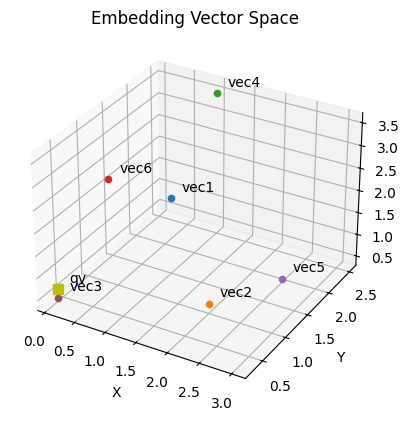

In [30]:
import matplotlib.pyplot as plt

# 3D 플롯을 생성합니다.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 각 벡터의 ID와 값을 사용하여 3D 공간에 점을 그립니다.
for i, id in enumerate(ids):
    if id == "qv":
        # 쿼리 벡터는 노란색 사각형으로 표시합니다.
        ax.scatter(values[i][0], values[i][1], values[i][2], label=id, color='y', s=50, marker='s')
        ax.text(values[i][0] + 0.1, values[i][1] + 0.1, values[i][2] + 0.1, id)
    else:
        # 나머지 벡터는 기본 색상으로 표시합니다.
        ax.scatter(values[i][0], values[i][1], values[i][2], label=id)
        ax.text(values[i][0] + 0.1, values[i][1] + 0.1, values[i][2] + 0.1, id)

# 축 레이블과 제목을 설정합니다.
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Embedding Vector Space')

# 플롯을 표시합니다.
plt.show()